In [1]:
import ase
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import torch
from mpltern.datasets import get_triangular_grid
from tqdm import tqdm

from alchemical_mace.calculator import get_alchemical_optimized_cellpar
from alchemical_mace.model import (
    AlchemicalPair,
    AlchemyManager,
    alchemical_mace_mp,
    get_z_table_and_r_max,
)
from alchemical_mace.optimize import ExponentiatedGradientDescent
from alchemical_mace.utils import suppress_print

plt.style.use("default")

### Cell parameter scan

In [2]:
# Default settings
model = "medium"
device = "cpu"

# Load pre-optimized structure (medium model)
atoms = ase.io.read("../data/structures/NaCl.cif")

# Construct the alchemical pairs
alkali_elements = ["Li", "Na", "K"]
alkali_idx = [i for i, atom in enumerate(atoms) if atom.symbol in alkali_elements]
alkali_atomic_numbers = [ase.Atoms(el).numbers[0] for el in alkali_elements]
alchemical_pairs = [
    [AlchemicalPair(atom_index=idx, atomic_number=z) for idx in alkali_idx]
    for z in alkali_atomic_numbers
]

In [3]:
# Compute lattice parameters for a triangular grid of compositions
comp_grid = np.array(get_triangular_grid(14))
lat_params = []
for comp in tqdm(comp_grid.T):
    with suppress_print(out=True, err=True):
        cellpar = get_alchemical_optimized_cellpar(
            atoms, alchemical_pairs, comp, model=model, device=device
        )
    lat_params.append(np.mean(cellpar[:3]))  # a = b = c

100%|██████████| 105/105 [05:25<00:00,  3.10s/it]


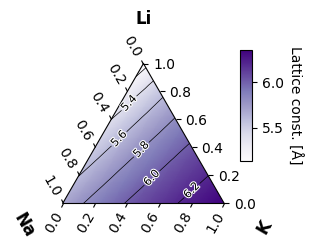

In [4]:
fig = plt.figure(figsize=(3, 3), layout="constrained")
ax = plt.subplot(projection="ternary")

cs = ax.tripcolor(*comp_grid, lat_params, cmap="Purples", shading="gouraud")
cax = ax.inset_axes([1.1, 0.3, 0.075, 0.8], transform=ax.transAxes)
cbar = fig.colorbar(cs, cax=cax)
cbar.set_label("Lattice const. [Å]", rotation=270, va="baseline")

cs = ax.tricontour(*comp_grid, lat_params, colors="k", linewidths=0.5, levels=6)
clabels = ax.clabel(cs)
for txt in clabels:
    txt.set_fontsize(8)
    txt.set_path_effects([pe.Stroke(linewidth=1.5, foreground="white"), pe.Normal()])
ax.set_tlabel("Li", weight="bold", fontsize=12)
ax.set_llabel("Na", weight="bold", fontsize=12)
ax.set_rlabel("K", weight="bold", fontsize=12)
fig.show()

### Stress gradient visualization

In [13]:
# Load alchemical MACE model
with suppress_print(out=True, err=True):
    mace = alchemical_mace_mp(model=model, device=device, default_dtype="float32")
for param in mace.parameters():
    param.requires_grad = False

# Set AlchemyManager
z_table, r_max = get_z_table_and_r_max(mace)
alchemical_weights = torch.ones(3, dtype=torch.float32) / 3
alchemy_manager = AlchemyManager(
    atoms=atoms,
    alchemical_pairs=alchemical_pairs,
    alchemical_weights=alchemical_weights,
    z_table=z_table,
    r_max=r_max,
).to(device)

# Common inputs
tensor_kwargs = {"dtype": torch.float32, "device": device}
positions = torch.tensor(atoms.get_positions(), **tensor_kwargs)
cell = torch.tensor(atoms.get_cell().array, **tensor_kwargs)

In [6]:
# Calculate hydrostatic stresses for a triangular grid of compositions
comp_grid = np.array(get_triangular_grid(14))
stress_list = []
for comp in tqdm(comp_grid.T):
    # Set alchemical weights
    alchemical_weights = torch.tensor(comp, dtype=torch.float32)
    alchemy_manager.alchemical_weights.data = alchemical_weights
    batch = alchemy_manager(positions, cell).to(device)

    # Get hydrostatic stress
    out = mace(batch, retain_graph=True, create_graph=True, compute_stress=True)
    stress = torch.abs(torch.trace(out["stress"][0])) / 3
    stress_list.append(stress.item())

# Calculate gradients for a small triangular grid of compositions
comp_grid_small = np.array(get_triangular_grid(10))
grad_list = []
for comp in tqdm(comp_grid_small.T):
    # Set alchemical weights
    alchemical_weights = torch.tensor(comp, dtype=torch.float32)
    alchemy_manager.alchemical_weights.data = alchemical_weights
    batch = alchemy_manager(positions, cell).to(device)

    # Get hydrostatic stress
    out = mace(batch, retain_graph=True, create_graph=True, compute_stress=True)
    stress = torch.abs(torch.trace(out["stress"][0])) / 3  # hydrostatic stress
    stress.backward()
    grad = alchemy_manager.alchemical_weights.grad
    grad_list.append(grad.clone().cpu().numpy())
    grad.data.zero_()

100%|██████████| 55/55 [00:09<00:00,  5.53it/s]


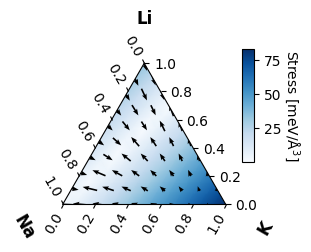

In [7]:
stress_list = np.array(stress_list)
grad_list = np.array(grad_list)

fig = plt.figure(figsize=(3, 3), layout="constrained")
ax = plt.subplot(projection="ternary")
cs = ax.tripcolor(*comp_grid, stress_list * 1e3, cmap="Blues", shading="gouraud")
cax = ax.inset_axes([1.1, 0.3, 0.075, 0.8], transform=ax.transAxes)
cbar = fig.colorbar(cs, cax=cax)
cbar.set_label("Stress [meV/Å$^3$]", rotation=270, va="baseline")
ax.quiver(
    *comp_grid_small,
    -grad_list[:, 0],
    -grad_list[:, 1],
    -grad_list[:, 2],
    color="k",
    scale=1.2,
    pivot="mid",
    linewidth=0.3,
    width=0.01,
    headlength=4,
    headaxislength=3.5,
)
ax.set_tlabel("Li", weight="bold", fontsize=12)
ax.set_llabel("Na", weight="bold", fontsize=12)
ax.set_rlabel("K", weight="bold", fontsize=12)
fig.show()

### Al(Sc,Y)N/GaN optimization

In [10]:
# Load structure
atoms = ase.io.read("../data/structures/GaN_hex.cif")
alch_elements = ["Al", "Sc"]
Ga_idx = [i for i, atom in enumerate(atoms) if atom.symbol == "Ga"]
alch_numbers = [ase.Atoms(el).numbers[0] for el in alch_elements]
alchemical_pairs = [
    [AlchemicalPair(atom_index=idx, atomic_number=z) for idx in Ga_idx]
    for z in alch_numbers
]

# Set AlchemyManager
z_table, r_max = get_z_table_and_r_max(mace)
alchemical_weights = torch.tensor([0.999, 0.001], dtype=torch.float32)
alchemy_manager = AlchemyManager(
    atoms=atoms,
    alchemical_pairs=alchemical_pairs,
    alchemical_weights=alchemical_weights,
    z_table=z_table,
    r_max=r_max,
).to(device)

# Common inputs
tensor_kwargs = {"dtype": torch.float32, "device": device}
cell = torch.tensor(atoms.get_cell().array, **tensor_kwargs, requires_grad=True)
frac_coords = torch.tensor(
    atoms.get_scaled_positions(), **tensor_kwargs, requires_grad=True
)

In [11]:
lr_weights = 5e-3
lr_cell = 1e-2
max_steps = 500
early_stop_loss = 5e-4

for i in range(max_steps):
    # Prepare data
    positions = frac_coords @ cell
    batch = alchemy_manager(positions, cell).to(device)

    # Get stress loss
    out = mace(batch, retain_graph=True, create_graph=True, compute_stress=True)
    stress = out["stress"][0]
    loss = torch.abs(stress[0, 0] + stress[1, 1])
    loss.backward()

    # Gradient update
    weights = alchemy_manager.alchemical_weights
    weights.grad -= weights.grad.mean()
    weights.data -= lr_weights * weights.grad
    weights.grad.zero_()

    c_update = cell.grad[2, 2].detach().clone()
    cell.grad.zero_()
    cell.grad[2, 2] = c_update  # only update the c component
    cell.data -= lr_cell * cell.grad
    cell.grad.zero_()

    if loss < early_stop_loss:
        break

In [12]:
print(weights.detach().cpu().numpy())

[0.8017931  0.19820715]
